In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()
from colossus.cosmology import cosmology

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))


reading ALFALFA table...
selected 4203 A.40 galaxies


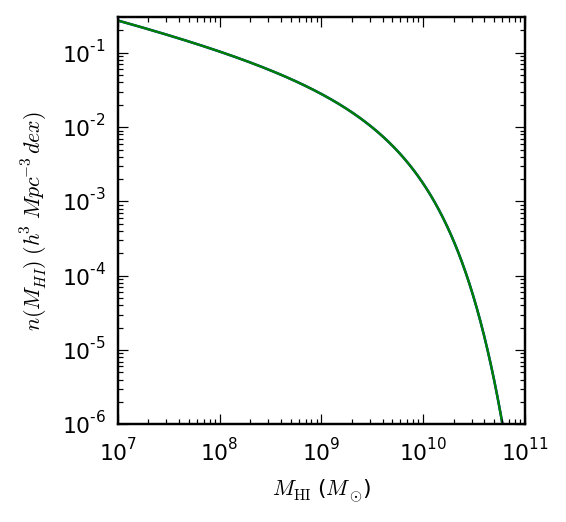

In [86]:
## getting HI mass function
import numpy as np

from code.setup import data_home_dir
from code.read_data import read_alfalfa

# read ALFALFA data and SDSS cross-listing table
print "reading ALFALFA table..."
aalist   = read_alfalfa(data_home_dir()+'a40.datafile1.txt');

# to match Martin et al. 2010  HI mass function procedure exactly, select only objects with HIcode = 1
# although Haynes et al. 2011 show that inclusion of HIcode = 2 objects does not bias results significantly
HIcode = aalist['HIcode']
HIfmin = 1.8

isel = ((HIcode==1) | (HIcode==2)) & (aalist['HIflux'] > HIfmin) & (aalist['Vhelio']<25000.)
aalist = aalist[isel]
d_L = aalist['Dist']; MHI = aalist['logMsun']; fHI = aalist['HIflux']

print "selected %d A.40 galaxies"%np.size(d_L)
#
# compute total solid angle of the ALFALFA.40 regions as quoted at the end of S 2 in Haynes et al. 2011 
#
def dOmega(a1, a2, d1, d2): 
    """
    solid angle of a contiguous rectangular region 
    define by right ascensions a1, a2 and declinations d1, d2
    """
    if d1 >= d2: 
        dmin = d2; dmax = d1
    else: 
        dmin = d1; dmax = d2 
    return np.abs(a2-a1)*(np.cos(dmin)-np.cos(dmax))

a11 = 7.5/12.; a12 = 16.5/12.; d11 = 4.0; d12 = 16.
d21 = 24.0; d22 = 28.
a31 = 22./12.; a32 = 3./12.; d31 = 14.; d32 = 16.
d41 = 24.0; d42 = 32.
a1 = a11*np.pi; a2 = a12*np.pi; d1 = d11*np.pi/180.; d2 = d12*np.pi/180.
o1 = dOmega(a1, a2, d1, d2)
d1 = d21*np.pi/180.; d2 = d22*np.pi/180.
o2 = dOmega(a1, a2, d1, d2)
a1 = a31*np.pi; a2 = a32*np.pi; d1 = d31*np.pi/180.; d2 = d32*np.pi/180.
o3 = dOmega(a1, a2, d1, d2)
d1 = d41*np.pi/180.; d2 = d42*np.pi/180.
o4 = dOmega(a1, a2, d1, d2)
otot = o1 + o2 + o3 + o4
from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')
z = data['z']
mr = data['petroMag_r'] - data['extinction_r']
data = data[(mr>=10.5) & (mr<17.77) & (z>0.0) & (z<1.0)]
mr = data['petroMag_r'] - data['extinction_r']
ra = data['ra']; dec = data['dec']; z = data['z']


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('WMAP9')
d_Ls = cosmo.luminosityDistance(z)/cosmo.h


# absolute magnitude in the r-band, accounting for extinction, evolution and K-correction
Mpetro = mr - 5.0*np.log10(d_Ls/1e-5) + 1.3*z 

a11s = a11*360.;  a12s = a12*360.; a31s = a31*360.; a32s = a32*360.

isel = (((a11s<ra) & (ra<=a12s) & (d11<dec) & (dec<=d12)) | 
        ((a11s<ra) & (ra<=a12s) & (d21<dec) & (dec<=d22)) | 
        ((a31s<ra) & (ra<=a32s) & (d31<dec) & (dec<=d32)) | 
        ((a31s<ra) & (ra<=a32s) & (d41<dec) & (dec<=d42)))
adata = data[isel]

zs = adata['z']; d_Ls = cosmo.luminosityDistance(zs)/cosmo.h
mr = adata['petroMag_r'] - adata['extinction_r']
Mpetro = mr - 5.0*np.log10(d_Ls/1e-5) + 1.3*zs


dLas = np.sort(d_L)
Na = np.size(dLas)
npdfa = np.array(range(Na))/(otot*dLas**3/3.)


Mlim = [-10., -12., -14., -17., -18., -19., -20.]
for Md in Mlim:
    isel2 = (Mpetro<Md)
    dLss = np.sort(d_Ls[isel2])
    Ns = np.size(dLss)
    npdfs = np.array(range(Ns))/(otot*dLss**3/3.)


# spline approximation
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

isel2 = (Mpetro<-9.)
dLss = np.sort(d_Ls[isel2])
Ns = np.size(dLss)
npdfs = np.array(range(Ns))/(otot*dLss**3/3.)

ndcorr = UnivariateSpline(dLss, npdfs)
ndcorr.set_smoothing_factor(.001)

ndsp = ndcorr(dLss)


def Vmax(HIfmin, MHI):
    dmax = np.sqrt(MHI/(2.356e5*HIfmin))
    return (dmax**3)/3.0 

lsscorr = ndcorr(np.maximum(12.,np.sqrt(10.**MHI/(2.356e5*HIfmin))))/1.9e-3
Vmaxi = 1.0/(lsscorr*otot*Vmax(HIfmin, 10**MHI))
Vmaxinc = 1.0/(otot*Vmax(HIfmin, 10**MHI))

nbins = 20
phi_HI, Mbins = np.histogram(MHI, weights=Vmaxi, bins=nbins)
phi_HI /= (Mbins[1] - Mbins[0])
Ngal, dbins = np.histogram(MHI, bins=nbins)
Mbinc = 0.5*(Mbins[1:]+Mbins[:-1])

# HI MF with LSS correction
phi_HImean, ephi_boot = compute_lf_bootstrap (MHI, Vmaxi, Mbins, nbootstraps = 100)
# without LSS correction
phi_HImeannc, ephi_bootnc = compute_lf_bootstrap (MHI, Vmaxinc, Mbins, nbootstraps = 100)
phi_HImean /= (Mbins[1] - Mbins[0])
phi_HImeannc /= (Mbins[1] - Mbins[0])

ephi_Poisson =  phi_HI[Ngal>0] / np.sqrt(Ngal[Ngal>0])
ephi = np.maximum(ephi_Poisson, ephi_boot[Ngal>0])

#ax.plot(10.**Mbinc[Ngal>0], phi_HImean[Ngal>0], c="b", label=r'$\mathrm{this\ work}$')
phi_HIm = phi_HImean[Ngal>0] - ephi; phi_HIp = phi_HImean[Ngal>0] + ephi
#plt.fill_between(10.**Mbinc[Ngal>0], phi_HIm, phi_HIp, facecolor='blue', alpha=0.5, interpolate=True)

datax = 10.**Mbinc[Ngal>0]
datay = phi_HImeannc[Ngal>0]
def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.set_xlabel(r"$M_{\rm HI}$ ($M_\odot$)")
ax.set_ylabel(r"$\Phi(M_{\rm HI})\ (\mathrm{Mpc^{-3}\, dex^{-1}})$")
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(1.e7,1.e11); ax.set_ylim(1.e-6,0.3)
phis = 6.0e-3; alpha = -0.25; Mstar = 9.91
Mbinc = np.linspace(7.0, 11., 1000)
#plt.plot(10.**Mbinc, lf_schechter(Mbinc, phis, Mstar, alpha), '--', c='b', label=r'$\mathrm{Martin\ et\ al.\ 10.}\ 1/V_{\rm max}$')
phis = 4.8e-3; alpha = -0.33; Mstar = 9.96
#plt.plot(10.**Mbinc, lf_schechter(Mbinc, phis, Mstar, alpha), '--', c='m', label=r'$\mathrm{M10,\ 2DSWML,\ Schechter\ fit}$')
ydata = lf_schechter(Mbinc,phis,Mstar,alpha)
xdata = 10.**Mbinc
ygood = ydata/xdata
spline_HI = UnivariateSpline(xdata, ygood, k=2,s=0)
#integrand = lambda x: spline_nsmt2(x)
mass = 10**np.linspace(7., 11., 1000)
nHI = np.zeros((len(mass)))
for i in range(len(mass)):
    #value, dummy = integrate.quad(integrand, mass[i], np.inf)
    nHI[i] = spline_HI.integral(mass[i], np.inf)
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
#plt.plot(mh, spline_nsmt2(mh))
plt.plot(mass, nHI)
HI_spline = UnivariateSpline(nHI[::-1], mass[::-1], k=1, s=0)
plt.plot(HI_spline(nHI), nHI)
plt.ylabel(r'$n(M_{HI})\ (h^3 Mpc^{-3} dex)$')

In [87]:
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

def compute_inverse_Vmax(mags, zs, m_min=None, m_max=None, cosmomodel='WMAP9'):
    """compute inverse Vmax for a given set of galaxy magnitudes and redshifts, given magnitude limits m_min and m_max"""
    #from code.calc_kcor import calc_kcor 
    #ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
    #kcorr = calc_kcor('r', zk, 'g - r', grm)
    from colossus.cosmology import cosmology
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology(cosmomodel)

    # compute luminosity and angular distances
    d_L = cosmo.luminosityDistance(zs)/cosmo.h

    # absolute magnitude in the r-band corrected for extinction
    Mabs = mags - 5.0*np.log10(d_L/1e-5) #- extm + 1.3*zs - kcorr; 

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mabs))/(1.+zs)
    d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mabs))/(1.+zs)

    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
    return vmaxi

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))
# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph, blah, blah2 = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 0.2
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

print "selected", np.size(zm), " after all cuts..."

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell = -.306 + 1.097*grm - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
Lmeert = Lmeert + lMsLrbell

d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
#d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

Lbinc = np.log10(10.**Lbinc*cosmo.h**2)


670722 galaxies in Meert et al. sample initially
selected 240053  after all cuts...


read 71474 GAMA galaxies
fscale: 0.0 45.8619185133
using 38362 GAMA galaxies for SMF
using 38950 GAMA galaxies for SMF


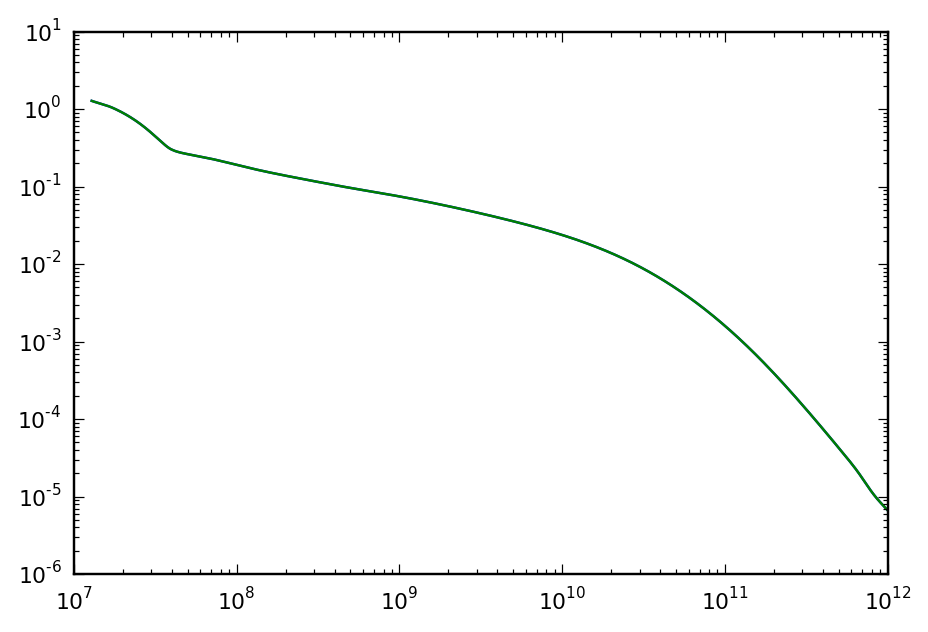

In [88]:

from code.setup import setup
import numpy as np

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
#data = read_GAMA(data_home_dir()+"GAMA_AEAtSz.fits")
data = read_GAMA(setup.data_home_dir()+"GAMA_DR2_full.fits")
print "read %d GAMA galaxies"%np.size(data['Z_HELIO'])

z_min = 0.001
z_max = 0.2
m_min = 10.5
m_max = 19.


mpetro = data['PETROMAG_R']-data['EXTINCTION_R']
data = data[((mpetro < m_max) & (mpetro > m_min))]; 
mg = data['GAL_MAG_G']; mi = data['GAL_MAG_I']; 
fscale = np.nan_to_num(data['fluxscale'])
print "fscale:", np.min(fscale), np.max(fscale)
mr = data['GAL_MAG_R'];
data = data[ (mg>1.) & (mg<25.) & (mi>1.) & (mi<25.)]; 
#data = data[(mr>1.) & (mr<20.) & (fscale < 1.5)]; 
#data = data[(fscale>0.) & (fscale < 1.5)]; 
data = data[data['Z_TONRY'] > z_min];   
data = data[data['Z_TONRY'] < z_max]
data = data[data['NQ'] >= 2]

mr = data['GAL_MAG_R']; Ar = data['A_r']
mi = data['GAL_MAG_I']; #Ar = data['A_i']
mg = data['GAL_MAG_G']; Ag = data['A_g']
#grg = mg - mr - Ag + Ar
gig = mg - mi
mrpetro = data['PETROMAG_R']
kcorr = data['KCORR_R']; kcorri = data['KCORR_I']
fscale = data['fluxscale']
lMstar = data['logmstar'] #+ 2.5*np.log(fscale)
Mstar = np.power(10.,lMstar)
zg = data['Z_HELIO']
d_Lm = cosmo.luminosityDistance(zg)/cosmo.h


# absolute magnitude in the r-band corrected for extinction
Mr = mr - 5.0*np.log10(d_Lm/1e-5) - Ar + 1.3*zg - kcorr; 
# 4.67 is the r-band luminosity in Lsun
Lr =  0.4*(4.67-(Mr)); 
Mi = mi - 5.0*np.log10(d_Lm/1e-5) + 1.3*zg - kcorri; 
Li =  0.4*(4.48-(Mi)); 
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
#lMsLrbell = -.306 + 1.097*grg - 0.1
lMsLibell = -0.152 + 0.518*gig - 0.1
#lMstar = Li + lMsLibell

Mrpetro = mrpetro - 5.0*np.log10(d_Lm/1e-5) - data['EXTINCTION_R'] #+ 1.3*zg - kcorr; 

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mrpetro))/(1.+zg)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mrpetro))/(1.+zg)
dmaxz = cosmo.luminosityDistance(z_max)/cosmo.h/(1.+zg)

d_Mmin = 0.; d_Mmax = np.minimum(d_Mmax,dmaxz)

vmaxim = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
#ccm = 1.0*np.size(vmaxim)/70726.
ccm = 0.98

solid_anglem = 144.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)

print "using %d GAMA galaxies for SMF"%np.size(vmaxim)


# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Msg, lMbins = np.histogram(lMstar, weights=vmaxim, bins=nbins)
lMbinc = 0.5 * (lMbins[1:] + lMbins[:-1]); dlMbins = (lMbins[1:]-lMbins[:-1])

phi_Msg, ephi_Msg = compute_lf_bootstrap(lMstar, vmaxim, lMbins, nbootstrap)

phi_Msg = phi_Msg  / dlMbins / cosmo.h**3
ephi_Msg = ephi_Msg  / dlMbins / cosmo.h**3
ephi_Msg = np.nan_to_num(ephi_Msg)

lMbinc = np.log10(10.**lMbinc*cosmo.h**2)

from code.setup import setup
import numpy as np

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)

data = read_GAMA(setup.data_home_dir()+"GAMA_DR2_full.fits")

z_min = 0.001
z_max = 0.2
m_min = 10.5
m_max = 19.

mrpetro = data['PETROMAG_R'] - data['EXTINCTION_R'] 
 
data = data[ (mrpetro < m_max) & (mrpetro > m_min) ]; 
zg = data['Z_HELIO']
data = data[ (zg > z_min) & (zg < z_max)];   

mrpetro = data['PETROMAG_R'] - data['EXTINCTION_R'] 
lMstar = data['logmstar']
zg = data['Z_HELIO']
d_Lm = cosmo.luminosityDistance(zg)/cosmo.h


Mrpetro = mrpetro - 5.0*np.log10(d_Lm/1e-5)#+ 1.3*zg - kcorr; 

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mrpetro))/(1.+zg)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mrpetro))/(1.+zg)
dmaxz = cosmo.luminosityDistance(z_max)/cosmo.h/(1.+zg)

d_Mmin = 0.; d_Mmax = np.minimum(d_Mmax,dmaxz)

vmaxim = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
#ccm = 1.0*np.size(vmaxim)/70726.
ccm = 0.98

solid_anglem = 144.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)

print "using %d GAMA galaxies for SMF"%np.size(vmaxim)


# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 50; nbins = 40
phi_Msg, lMbins = np.histogram(lMstar, weights=vmaxim, bins=nbins)
lMbinc = 0.5 * (lMbins[1:] + lMbins[:-1]); dlMbins = (lMbins[1:]-lMbins[:-1])

phi_Msg, ephi_Msg = compute_lf_bootstrap(lMstar, vmaxim, lMbins, nbootstrap)

phi_Msg = phi_Msg  / dlMbins / cosmo.h**3
ephi_Msg = ephi_Msg  / dlMbins / cosmo.h**3
ephi_Msg = np.nan_to_num(ephi_Msg)

lMbinc = np.log10(10.**lMbinc*cosmo.h**2)

#plt.plot(10.**lMbinc, phi_Msg, c='m', label=r'$\mathrm{GAMA}$')
phi_Msgm = phi_Msg-ephi_Msg; phi_Msgp = phi_Msg+ephi_Msg

# analytic fit from Baldry et al. 2012
mstar = 10.**10.66 ; phis1 = 3.96e-3; alpha1 = -0.35; 
phis2 = 0.79e-3; mstarg = 2.7031e9; alpha2 = -1.47

lms = np.linspace(6.,12.5,200)
ms = 10.**lms

mus = ms/mstar; 
phiB12 = np.log(10.)*np.exp(-mus)*(phis1*mus**alpha1 + phis2*mus**alpha2)*mus

# spline approximation
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

phisp_GAMA = UnivariateSpline(lMbinc, np.log10(phi_Msg))
phisp_GAMA.set_smoothing_factor(.01)

phisp_M15 = UnivariateSpline(Lbinc[phi_Lbsmeert>0], np.log10(phi_Lbsmeert[phi_Lbsmeert>0]))
phisp_M15.set_smoothing_factor(.01)

lms = np.linspace(6.,12.5,200)
ms = 10.**lms

phispdG = phisp_GAMA(lms); phispdM = phisp_M15(lms)
phisp = np.maximum(phispdG,phispdM)
stellar_datay = phisp
indices = np.where((phisp < 0.0) & (phisp > -6))
#plt.plot(ms[indices], 10.**phisp[indices], lw=2.0, c='darkviolet')
#plt.xlim([1.e7, 3e12]); plt.ylim([1E-6, 1.0])
plt.xscale('log'); plt.yscale('log')
stellar_datax = ms[indices] #cutting out the bad data
stellar_datay = 10.**phisp[indices]
stellarygood = stellar_datay/stellar_datax
spline_stellar = UnivariateSpline(stellar_datax, stellarygood,k=1,s=0)
#spline_stellar.set_smoothing_factor(.1)
#integrand = lambda x: spline_nsmt2(x)
mass = 10**np.linspace(7.1, 12., 1000)
#mass = np.linspace(10**5., 10.**12., 1000)
nstellar = np.zeros((len(mass)))
for i in range(len(mass)):
    #value, dummy = integrate.quad(integrand, mass[i], np.inf)
    nstellar[i] = spline_stellar.integral(mass[i], np.inf)
stellar_spline1 = UnivariateSpline(mass,nstellar, k=1,s=0)
nstellar = nstellar[2:] #cutting out parts so nstellar is  monotonic
mass = mass[2:]
stellar_spline = UnivariateSpline(nstellar[::-1],mass[::-1],k=1,s=0)
plt.plot(mass,stellar_spline1(mass))
plt.plot(stellar_spline(nstellar), nstellar)

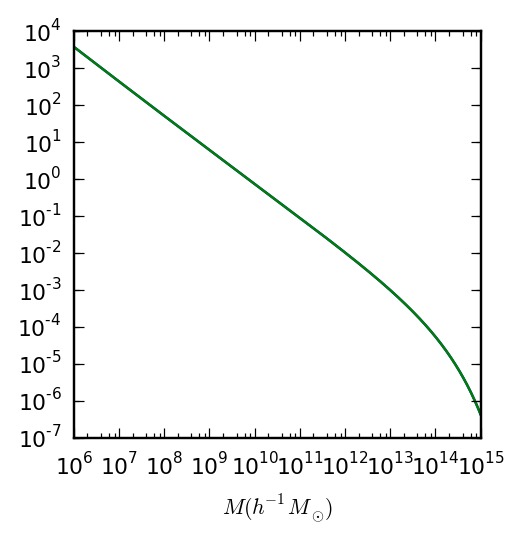

In [89]:

import numpy as np
from matplotlib import pylab as plt
from colossus.cosmology import cosmology
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy as scipy


# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False

z0=0.0
z = np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])

fig = plt.figure(figsize = (3,3))
from code.plot_utils import plot_pretty
#plot_pretty()

# grid of halo masses in /h Msun
lmh = np.arange(6.,15.5,0.05)
mh = np.power(10.,lmh)
# compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
rh = cosmo.lagrangianR(mh)
# compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
sig = cosmo.sigma(rh,z0)
# and its logarithmic derivative dlog(sigma)/dlogR
dsdr = cosmo.sigma(rh, z0, derivative='True')
# dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
dsdm = dsdr / 3.0
def fsub(mh, z):
    """
    subhalo fraction calibration from the Appendix G of Behroozi et al. 2013
    as a function of Mpeak - eqs G9-10
    input: mh = halo mass in Msun
           z  = redshift
    """
    aexp = 1.0/(1.0+z)
    aexp2 = aexp*aexp; aexp3 = aexp2*aexp; aexp4 = aexp3*aexp
    Ca = -1.91 + 6.23*aexp - 15.07*aexp2 + 15.02*aexp3  - 5.29*aexp4
    Mcutoff = 10.66 + 15.93*aexp - 21.39*aexp2 + 18.20*aexp3 - 8.21*aexp4
    return 10.**Ca*np.log10(10.**Mcutoff/mh)
fsubfrac = np.zeros((len(mh)))
for i in range(len(mh)):
    fsubfrac[i]= fsub(mh[i], z[0])
#
#  SMT01 mass function parameters
#
q_smt = 0.3; A_smt = 0.322; a_smt = 0.707

nu = cosmo.peakHeight(mh, 0.0)
nup = np.sqrt(a_smt)*nu
nps = np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*nu*np.abs(dsdm)*np.exp(-0.5*nu**2)
nsmt = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nu**(2.*q_smt))*nu*np.abs(dsdm)*np.exp(-0.5*nu**2)
nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M (h^{-1} M_{\odot})$')
#plt.ylabel(r'$n(M_*) (h^3 Mpc^{-3}})$')
plt.yscale('log'); plt.xscale('log')
#plt.xlim(1.e6, 1.e15); plt.ylim(1.e-7,1.e3)
cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

z = np.array([0.0])
lstyles = ['-','--','-.',':','-','--','-.']
nc = np.zeros_like(z)
for i, zd in enumerate(z): nc[i] = np.int(30.*(20.0-zd)/30.0)
color = scalarmap.to_rgba(nc)

for i,zd in enumerate(z):
    nu = cosmo.peakHeight(mh, zd)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm*cosmo.growthFactor(zd)
    nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)*(1+fsubfrac)
    #plt.plot(mh,nsmt2,c=color[i], ls=lstyles[i], linewidth=2.0, label=r'$z=%.1f$'%zd)
#inverse_halo = scipy.integrate.cumtrapz(nsmt2/mh, mh, initial=0)
#densityhalo = inverse_halo[-1] - inverse_halo
#spline_halo = UnivariateSpline(densityhalo[::-1], mh[::-1], k=2, s=0)
nsmtgood = nsmt2/mh
import scipy.integrate as integrate
spline_nsmt2 = UnivariateSpline(mh, nsmtgood, k=2,s=0)
#integrand = lambda x: spline_nsmt2(x)
mass = 10**np.linspace(6., 15., 1000)
nhalo = np.zeros((len(mass)))
for i in range(len(mass)):
    #value, dummy = integrate.quad(integrand, mass[i], np.inf)
    nhalo[i] = spline_nsmt2.integral(mass[i], np.inf)*np.log(10)
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
#plt.plot(mh, spline_nsmt2(mh))
plt.plot(mass, nhalo)
halo_spline = UnivariateSpline(nhalo[::-1], mass[::-1], k=2, s=0)
plt.plot(halo_spline(nhalo), nhalo)

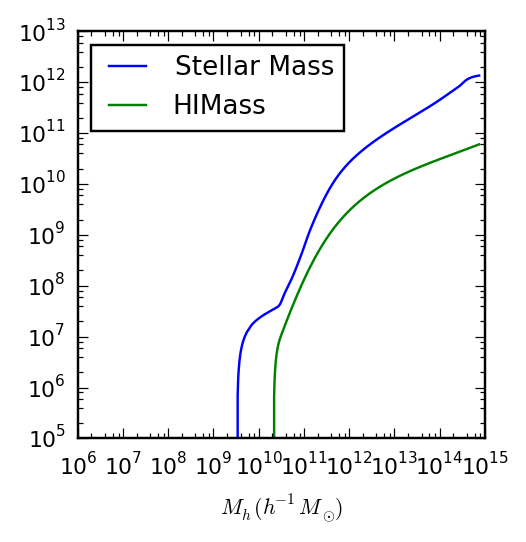

In [90]:
## abundance matching
fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M_h (h^{-1} M_{\odot})$'); #plt.ylabel('M (h^{-1} M_{\odot})')
plt.yscale('log'); plt.xscale('log')
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
densities = 10**np.linspace(3., -6.0, 1000)
HaloMass = halo_spline(densities)
StellarMass = stellar_spline(densities)
HIMass = HI_spline(densities)
plt.plot(HaloMass, StellarMass, label = 'Stellar Mass')
plt.plot(HaloMass, HIMass, label = 'HIMass')
plt.legend(loc='best')

The above plot shows the $M_* - M_h$ relation. Sorry for the lack of y-axis label, for some reason, python started complaining about the plt.ylabel() function, since it's not very important, I just lefted it out. The y axis is the $M_*$ quantitity. I normalized everything to the "dex" unit, meaning I multiplied the halo density differential function by $\ln(10)$.

(1e-07, 10.0)

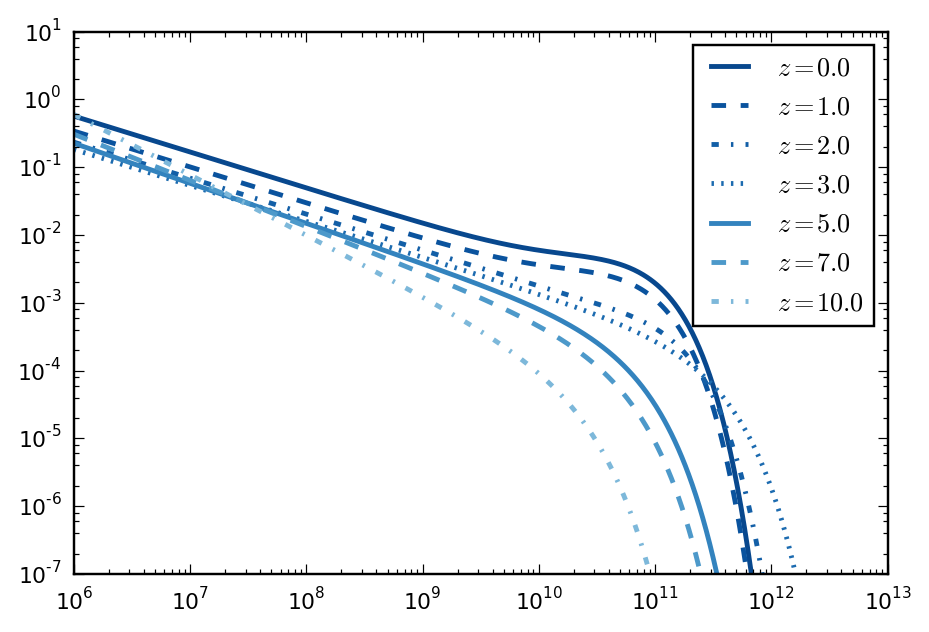

In [91]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm
import matplotlib.colors as colors

def nmstz(ms, z):
    """
    compute analytic double Schechter representation of the observed stellar mass function as a function
    of redshift using calibration of Leja et al. 2015, 798, 115 (see eqs in their S 2)
    note that this calibration is for 3<z<0 - I checked it gives grossly incorrect results at z>3
    
    input: ms - array of stellar masses
            z - redshift
    output: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    if z <= 3.0:
        z2 = z * z; lms = np.log10(ms)
        lphi1 = -2.46 + 0.07*z - 0.28*z2 
        lphi2 = -3.11 - 0.18*z - 0.03*z2
        lmst  = 10.72 - 0.13*z + 0.11*z2
        mst = np.power(10.,lmst); mus = ms/mst
        a1 = -0.39; a2 = -1.53
        nmstz = np.log(10.)*np.exp(-mus)*(mus)*(10.**lphi1*mus**a1+10.**lphi2*mus**a2)
    else:
        """
        high-z SMF estimates from CANDELS and S-CANDELS from the talk by Song 
        http://www.astrodeep.eu/wp-content/uploads/2015/02/MSong.sesto_.Jan2015.pdf
        """
        z_h     = [4.0, 5.0, 6.0, 7.0]
        lmst_z  = [10.68, 10.58, 10.22, 10.45]
        ah_z    = [-1.59, -1.68, -1.89, -1.93]
        lphi_z = [-3.77, -3.99, -4.34, -4.94]

        lmst  = UnivariateSpline(z_h, lmst_z)
        ahz   = UnivariateSpline(z_h, ah_z)
        lphiz = UnivariateSpline(z_h, lphi_z)
        a = ahz(z); mst = np.power(10., lmst(z)); phiz = np.power(10.,lphiz(z))
        mus = ms/mst
        nmstz = np.log(10.)*phiz*np.exp(-mus)*(mus)**(a + 1.0)

    return nmstz


lms = np.arange(6., 12.6, 0.01)
ms = np.power(10., lms)
z = np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])
philejaz = np.zeros((len(ms), len(z)))
for i in range(len(z)):
    philejaz[:,i] = nmstz(ms,i)
cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)
lstyles = ['-','--','-.',':','-','--','-.']
nc = np.zeros_like(z)
for i, zd in enumerate(z): nc[i] = np.int(30.*(20.0-zd)/30.0)
color = scalarmap.to_rgba(nc)
for i,zd in enumerate(z):
    plt.plot(ms,philejaz[:,i],c=color[i], ls=lstyles[i], linewidth=2.0, label=r'$z=%.1f$'%zd)
plt.legend(loc='best')
plt.yscale('log'); plt.xscale('log')
plt.xlim(1.e6, 1.e13); plt.ylim(1.e-7,1.e1)


There are some differences with the halo mass function. For one thing the halo mass functions do not cross with each other while these plots do (e.g. in this plot, $z=3$ has a drop off later than the other functions. There's also a bump around $10^{11}$ stellar mass for $z=1$ and $z=0$. There is also an offset compared to the halo mass function since the stellar mass is much smaller than halo mass, by orders of magnitude. The shapes are also different since the equations are not self-similar unlike the equations in question 2's galaxy_model.

[0, 1, 2, 3, 4, 5, 6]


(10000000000, 10000000000000)

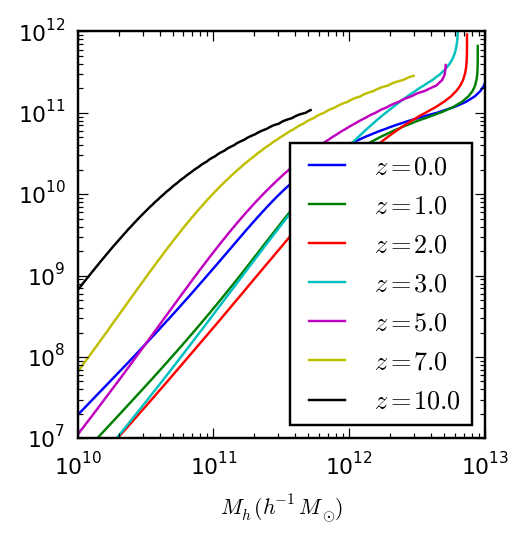

In [92]:
 ## abundance matching
fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M_h (h^{-1} M_{\odot})$'); #plt.ylabel('M (h^{-1} M_{\odot})')
plt.yscale('log'); plt.xscale('log')
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

mass = 10**np.linspace(6., 12.6, 100)
stellarl_spline = np.zeros((len(z), len(mass)))
lmh = np.arange(6.,15.5,0.05)
mh = np.power(10.,lmh)
halol_nsmt = np.zeros((len(z),len(mh)))
i=0
for i,zd in enumerate(z):
    nu = cosmo.peakHeight(mh, zd)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm*cosmo.growthFactor(zd)
    nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)
    halol_nsmt[i,:] = nsmt2
#    plt.plot(mh,nsmt2,c=color[i], ls=lstyles[i], linewidth=2.0, label=r'$z=%.1f$'%zd)
mass = 10**np.linspace(6., 12.6, 100)
i=0
print range(len(z))
#splining the Leja SMFs & smts
densities = 10**np.linspace(3., -8.0, 1000)
for i in range(len(z)):
    nsmtl0good = philejaz[:,i]/ms
    spline_nsmtl0 = UnivariateSpline(ms, nsmtl0good, k=2,s=0)
    nstellarl0 = np.zeros((len(mass)))
    for j in range(len(mass)):
        nstellarl0[j] = spline_nsmtl0.integral(mass[j], np.inf)*np.log(10)
    stellarl_spline = UnivariateSpline(nstellarl0[::-1], mass[::-1], k=1, s=0)
    
    nsmtgood1 = halol_nsmt[i,:]/mh
    spline_nsmt2 = UnivariateSpline(mh, nsmtgood1, k=2,s=0)
    nhalo = np.zeros((len(mass)))
    for x in range(len(mass)):
        nhalo[x] = spline_nsmt2.integral(mass[x], np.inf)*np.log(10)
    halol_spline = UnivariateSpline(nhalo[::-1], mass[::-1], k=2, s=0)
    #plt.plot(halol_spline(nhalo),nhalo)
    #plt.plot(stellarl_spline(nstellarl0), nstellarl0)
    
    halomass = halol_spline(densities)
    stellarlmass = stellarl_spline(densities)
    plt.plot(halomass, stellarlmass, label=r'$z=%.1f$'%z[i])
plt.legend(loc='best')
plt.ylim([10**7., 10.**12]);plt.xlim([10**10,10**13])

Between $0 < z < 2$, the mass function shifts right, meaning for a given halo mass, the stellar mass deceases. After this epoch however, the mass function begins to shift left. By $z=5$, the mass function is pretty much completely to the left of the $z=0$ plot, the slope also appears to steepen for $3 <z <7$. There is a curve seen at around $10^{13}$ halo mass, this is likely due to numerical effects from using splines. Beyond that, it seems to match well with Behroozi's results. We see the plot having a break around a halo mass of $10^{12}$.
If we plot the stellar mass to halo mass ratios, it peaks around a halo mass of $10^{12}$, which indicates steeply
falling star formation efficiencies at higher and lower masses.

# Question #2

In [93]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
from scipy.integrate import odeint

def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = gm.model_galaxy(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout

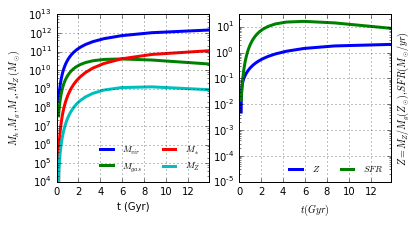

In [94]:

sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe

fig, ax = plt.subplots(1,2, figsize=(6,3))    
ax[0].set_xlabel('t (Gyr)'); ax[0].set_ylabel(r'$M_h, M_g, M_*, M_Z (M_{\odot})$')
ax[0].set_xlim(0.,tu); ax[0].set_ylim(1.e4,1.e13)
ax[0].set_yscale('log')
ax[0].plot(t_output, Mhout, lw = 3.0, label=r'$M_{vir}$')
ax[0].plot(t_output, Mgout, lw = 3.0, label=r'$M_{gas}$')
ax[0].plot(t_output, Msout, lw = 3.0, label=r'$M_{*}$')
ax[0].plot(t_output, MZout, lw = 3.0, label=r'$M_{Z}$')

ax[0].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[0].grid()
    
# plot SFR and Z(t)
ax[1].set_xlabel(r'$t (Gyr)$'); ax[1].set_ylabel(r'$Z= M_{Z}/M_{g} (Z_{\odot}),SFR (M_{\odot}/yr)$')
ax[1].set_xlim(0.,tu); ax[1].set_ylim(1.e-5,30.)
ax[1].set_yscale('log')
ax[1].yaxis.set_label_position('right')


ax[1].plot(t_output, MZout/Mgout/0.02, lw = 3.0, label=r'$Z$')
SFR = np.zeros_like(t_output); 

for i, td in enumerate(t_output):
    ge = gm.model_galaxy(t = td, Mh = Mhout[i], Mg = Mgout[i], Ms = Msout[i], MZ = MZout[i], 
                         sfrmodel = sfrmodel, cosmo = cosmo)
    SFR[i] = ge.SFR(td)*1.e-9;

ax[1].plot(t_output,SFR, lw = 3.0, label=r'$SFR$')
ax[1].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[1].grid()
plt.show()

Yes, the results do seem reasonable to me. We can see the that time scale for star formation which is $2.5Gy$, as discussed in class, after which $M_g$ began decreasing and things began to even out. The virial mass can be determined by the overdensity profiles of peaks (plot of $\delta$ vs $r$ in the notes), which can be computed from gaussian field statistics, and the spherical collapse model. At high redshifts, peak height favours small masses (Fig 2.3 in the notes), but the likelihood of higher mass halos collapsing rapidly increases as we go to smaller z. The stellar mass function shape is very similar to virial mass function due to the self-similar equations.

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


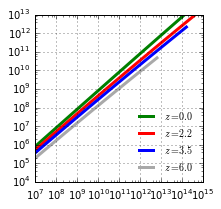

In [95]:
from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = gm.model_galaxy(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
#plt.xlabel(r'$M_h (M_\odot)$')
#plt.ylabel(r'$M_{*} (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)
            
plt.legend(frameon=False,loc='lower right', fontsize=10)
plt.grid()
plt.show()

The relation we get is different from what was plotted for question #1. This is because the equations governing this, as mentioned before, are self-similar. The $z=6$ relation is the lowest since the timescale for star formation is around 2.5Gyr. 

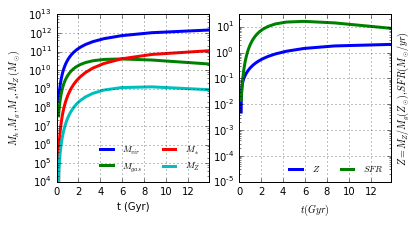

In [96]:
import code.galaxy_model1 as my_galaxy_model

def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = my_galaxy_model.model_galaxy(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout

sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe

fig, ax = plt.subplots(1,2, figsize=(6,3))    
ax[0].set_xlabel('t (Gyr)'); ax[0].set_ylabel(r'$M_h, M_g, M_*, M_Z (M_{\odot})$')
ax[0].set_xlim(0.,tu); ax[0].set_ylim(1.e4,1.e13)
ax[0].set_yscale('log')
ax[0].plot(t_output, Mhout, lw = 3.0, label=r'$M_{vir}$')
ax[0].plot(t_output, Mgout, lw = 3.0, label=r'$M_{gas}$')
ax[0].plot(t_output, Msout, lw = 3.0, label=r'$M_{*}$')
ax[0].plot(t_output, MZout, lw = 3.0, label=r'$M_{Z}$')

ax[0].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[0].grid()
    
# plot SFR and Z(t)
ax[1].set_xlabel(r'$t (Gyr)$'); ax[1].set_ylabel(r'$Z= M_{Z}/M_{g} (Z_{\odot}),SFR (M_{\odot}/yr)$')
ax[1].set_xlim(0.,tu); ax[1].set_ylim(1.e-5,30.)
ax[1].set_yscale('log')
ax[1].yaxis.set_label_position('right')


ax[1].plot(t_output, MZout/Mgout/0.02, lw = 3.0, label=r'$Z$')
SFR = np.zeros_like(t_output); 

for i, td in enumerate(t_output):
    ge = my_galaxy_model.model_galaxy(t = td, Mh = Mhout[i], Mg = Mgout[i], Ms = Msout[i], MZ = MZout[i], 
                         sfrmodel = sfrmodel, cosmo = cosmo)
    SFR[i] = ge.SFR(td)*1.e-9;

ax[1].plot(t_output,SFR, lw = 3.0, label=r'$SFR$')
ax[1].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[1].grid()
plt.show()

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


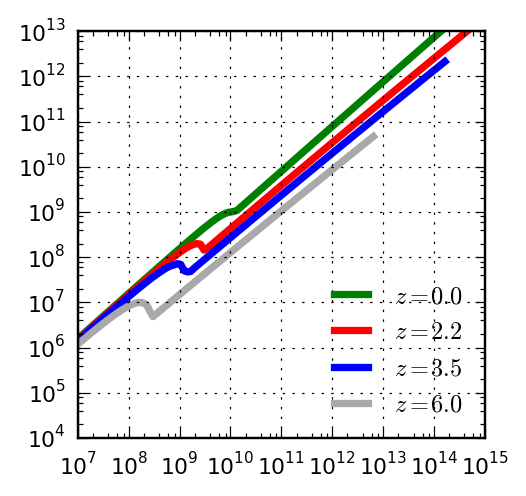

In [97]:
from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = my_galaxy_model.model_galaxy(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
#plt.xlabel(r'$M_h (M_\odot)$')
#plt.ylabel(r'$M_{*} (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)
            
plt.legend(frameon=False,loc='lower right', fontsize=10)
plt.grid()
plt.show()

Suppression does have an effect. We can see the cut off mass causing a dip in the relation. The effect seems quite strong here, this may be due to the fact I implemented a straight step functions in fg_in rather than the exact form of the equation but it still illustrates the effect. (Sorry for lack of labels but the axis label is same as before)

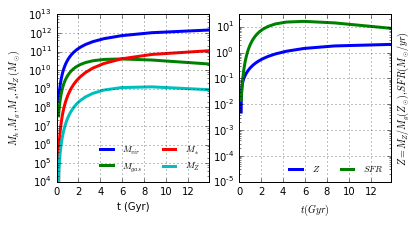

In [98]:
import code.galaxy_model2 as my_galaxy_model2
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)


def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = my_galaxy_model2.model_galaxy(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout

sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe

fig, ax = plt.subplots(1,2, figsize=(6,3))    
ax[0].set_xlabel('t (Gyr)'); ax[0].set_ylabel(r'$M_h, M_g, M_*, M_Z (M_{\odot})$')
ax[0].set_xlim(0.,tu); ax[0].set_ylim(1.e4,1.e13)
ax[0].set_yscale('log')
ax[0].plot(t_output, Mhout, lw = 3.0, label=r'$M_{vir}$')
ax[0].plot(t_output, Mgout, lw = 3.0, label=r'$M_{gas}$')
ax[0].plot(t_output, Msout, lw = 3.0, label=r'$M_{*}$')
ax[0].plot(t_output, MZout, lw = 3.0, label=r'$M_{Z}$')

ax[0].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[0].grid()
    
# plot SFR and Z(t)
ax[1].set_xlabel(r'$t (Gyr)$'); ax[1].set_ylabel(r'$Z= M_{Z}/M_{g} (Z_{\odot}),SFR (M_{\odot}/yr)$')
ax[1].set_xlim(0.,tu); ax[1].set_ylim(1.e-5,30.)
ax[1].set_yscale('log')
ax[1].yaxis.set_label_position('right')


ax[1].plot(t_output, MZout/Mgout/0.02, lw = 3.0, label=r'$Z$')
SFR = np.zeros_like(t_output); 

for i, td in enumerate(t_output):
    ge = my_galaxy_model2.model_galaxy(t = td, Mh = Mhout[i], Mg = Mgout[i], Ms = Msout[i], MZ = MZout[i], 
                         sfrmodel = sfrmodel, cosmo = cosmo)
    SFR[i] = ge.SFR(td)*1.e-9;

ax[1].plot(t_output,SFR, lw = 3.0, label=r'$SFR$')
ax[1].legend(frameon=False,loc='lower right', ncol=2, fontsize=9)
ax[1].grid()
plt.show()

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


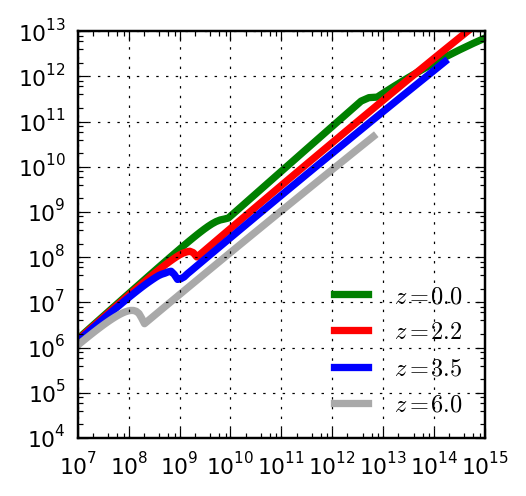

In [99]:
from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = my_galaxy_model2.model_galaxy(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
#
# plot
#

fig = plt.figure(figsize=(3, 3))
plot_pretty()
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
#plt.xlabel('$M_h (M_\odot)$')
#plt.ylabel('$M_{*} (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)
            
plt.legend(frameon=False,loc='lower right', fontsize=10)
plt.grid()
plt.show()

Yes, this seems to bring the relation closer to what we see in number 1, especially the plateau-ing of the $z=0$ relation. The other relations do not seem to have much effects. This is due to $M_{ps}$ being large for large $z$'s, and  not affecting the relation at this mass range.